In [813]:
import sys
import random
import time
import matplotlib.pyplot as plt
import numpy as np

sys.setrecursionlimit(10**6)

In [814]:
class Island:
    def __init__(self, x, y, cost, pos):
        self.x = x
        self.y = y
        self.cost = cost
        self.pos = pos

In [815]:
class IslandList(list):
    def load(self):
        x, y = np.zeros(len(self)), np.zeros(len(self))
        for i, island in enumerate(self):
            x[i] = island.x
            y[i] = island.y
        return x, y
    
    def costs(self):
        c = np.zeros(len(self))
        for i, island in enumerate(self):
            c[i] = island.cost
        return c


In [816]:
def point_dist(p1, p2):
    return ((p1.x - p2.x)**2 + (p1.y - p2.y)**2)**0.5

In [817]:
fr = open('in', 'r')

In [818]:
n, p, k, M = list(map(int, fr.readline().split()))
islands = IslandList()

for i in range(n):
    cx, cy, c_cost = list(map(int, fr.readline().split()))
    islands.append(Island(cx, cy, c_cost, i))

#random.shuffle(islands)
zero_pos = -1
for i, island in enumerate(islands):
    if island.pos == 0:
        zero_pos = i

In [819]:
print("Points: {}, Cost per one: {}, Memory: {}, Max sum memory: {}".format(n, p, k, M))

Points: 980, Cost per one: 20, Memory: 5, Max sum memory: 10000


In [820]:
x, y = islands.load()
costs = islands.costs()

Визуализируем данные.

In [821]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
orange = (1.0, 0.4980392156862745, 0.054901960784313725)

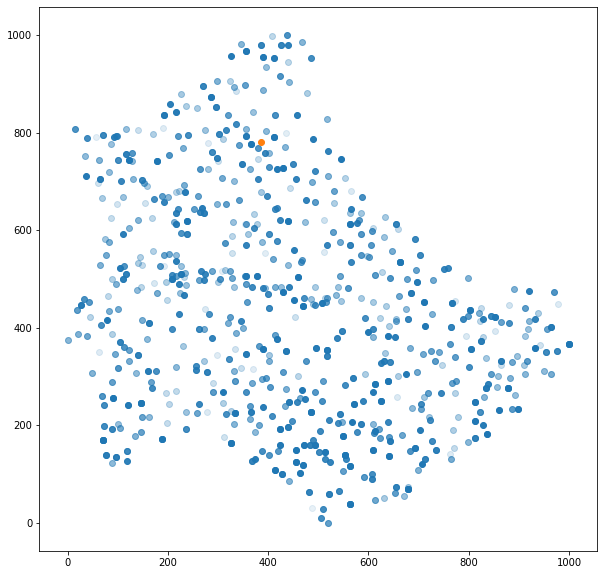

In [822]:
plt.figure(figsize=(10, 10))

for i in np.arange(x.shape[0]):
    plt.scatter(x[i], y[i], color=blue, alpha=costs[i]/np.max(costs))

plt.scatter(x[zero_pos], y[zero_pos], color=orange)

plt.show()

In [823]:
np.max(costs)

1995.0

Судя по максимуму можно заметить, что параметр на ограничение денег не очень сильно влияет. На 5 посещенный островов в среднем 3 могут быть точно самыми оптимальными.

Возьмем некоторый порог точек, на которых будет базироваться ответ, остальные точки буду вспомогательными для не привышения лимита.

In [824]:
good_x = x[costs > 1000]
good_y = y[costs > 1000]
good_costs = costs[costs > 1000]

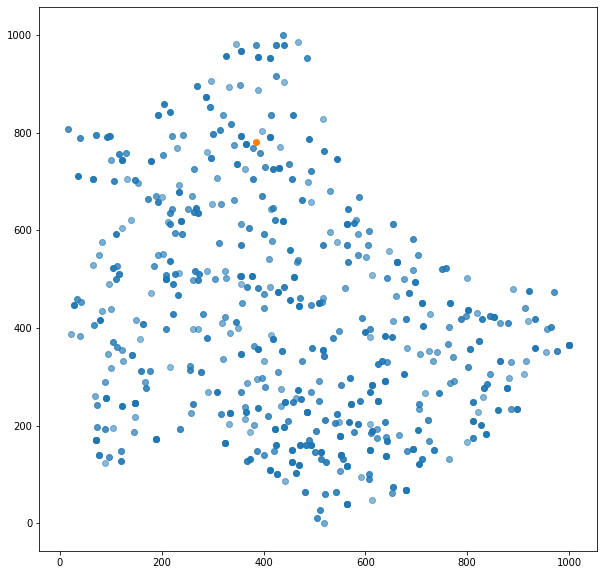

In [825]:
plt.figure(figsize=(10, 10))

for i in np.arange(good_x.shape[0]):
    plt.scatter(good_x[i], good_y[i], color=blue, alpha=good_costs[i]/np.max(good_costs))

plt.scatter(x[zero_pos], y[zero_pos], color=orange)

plt.show()

Построим MST.

In [826]:
special = costs > 500
special[zero_pos] = True

In [827]:
edges = []

dists = [(np.inf, -1)] * n
takes = [0] * n
dists[zero_pos] = (0, 0)

In [828]:
for i in range(n):
    take = -1
    for j in range(n):
        if dists[j][0] != np.inf and takes[j] == 0 and special[j] and (take == -1 or dists[take][0] > dists[j][0]):
            take = j
    if take == -1:
        break
        
    edges.append((take, dists[take][1]))
        
    takes[take] = 1
    for j in range(n):
        if point_dist(islands[take], islands[j]) < dists[j][0]:
            dists[j] = (point_dist(islands[take], islands[j]), take)


In [829]:
edges = edges[1:]

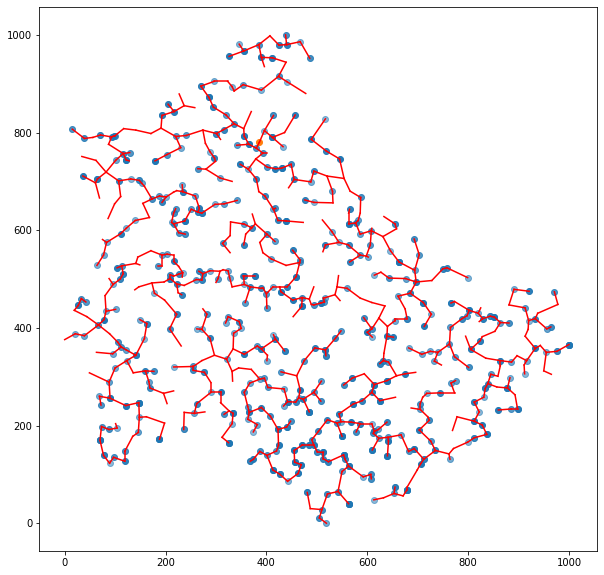

In [830]:
plt.figure(figsize=(10, 10))

for i in np.arange(1, good_x.shape[0]):
    plt.scatter(good_x[i], good_y[i], color=blue, alpha=good_costs[i]/np.max(good_costs))

plt.scatter(x[zero_pos], y[zero_pos], color=orange)

for edge in edges:
    x1, y1 = islands[edge[0]].x, islands[edge[0]].y
    x2, y2 = islands[edge[1]].x, islands[edge[1]].y
    plt.plot([x1, x2], [y1, y2], c='red')

plt.show()

In [831]:
def check(result_path):
    d = deque()
    summary = 0
    for i in range(1, len(result_path)):
        cur = islands[result_path[i]].cost
        summary += cur
        d.append(cur)
        if len(d) == k + 1:
            d.popleft()
        if sum(d) > M:
            return False
    return True

In [832]:
tree = [[] for i in range(n)]

for edge in edges:
    tree[edge[0]].append(edge[1])
    tree[edge[1]].append(edge[0])

In [833]:
been = [0] * n
path = []

def dfs(v):
    been[v] = 1
    path.append(v)
    
    for nextv in tree[v]:
        if been[nextv] == 0:
            dfs(nextv)

dfs(zero_pos)            
path.append(zero_pos)

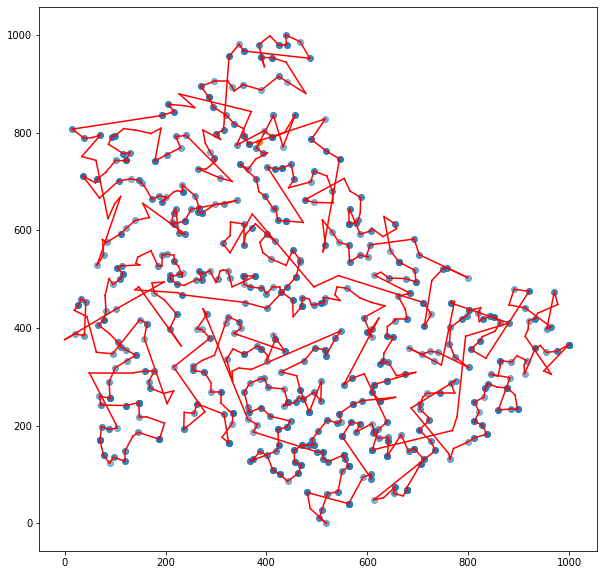

In [834]:
plt.figure(figsize=(10, 10))

for i in np.arange(1, good_x.shape[0]):
    plt.scatter(good_x[i], good_y[i], color=blue, alpha=good_costs[i]/np.max(good_costs))

plt.scatter(x[zero_pos], y[zero_pos], color=orange)

for i in range(1, len(path)):
    x1, y1 = islands[path[i - 1]].x, islands[path[i - 1]].y
    x2, y2 = islands[path[i]].x, islands[path[i]].y
    plt.plot([x1, x2], [y1, y2], c='red')
plt.show()

In [835]:
from collections import deque

lasts = deque()

available = list(special)
def get_special(island_num):
    global available
    
    best = -1
    for i in range(len(available)):
        if not available[i]:
            if best == -1 or point_dist(islands[island_num], islands[i]) < point_dist(islands[island_num],
                                                                                      islands[best]):
                best = i
    if best != -1:
        pass
    available[best] = True
    return best
    

result_path = [zero_pos]
for i in range(1, len(path)):
    cur = islands[path[i]].cost
    result_path.append(path[i])
    lasts.append(cur)
    
    if len(lasts) == k + 1:
        lasts.popleft()
    
    while sum(lasts) > M:
        #reverting
        i1 = result_path[-1]        
        lasts.pop()

        result_path = result_path[:-1]
        
        p1 = get_special(result_path[-1])
        if p1 == -1:
            break
        
        assert not(p1 in result_path)
        cur = islands[p1].cost
        lasts.append(cur)
        result_path.append(p1)        
        
        assert sum(lasts) <= M
        
        lasts.popleft()
        
        cur = islands[i1].cost
        lasts.append(cur)
        result_path.append(i1)

for i in range(3):
    for i in range(len(available)):
        if not available[i]:
            best = 0
            pos = -1
            for j in range(1, len(result_path)):
                a, b = result_path[j - 1], result_path[j]

                cur = point_dist(islands[a], islands[b]) * p
                cur = cur - point_dist(islands[a], islands[i]) * p - point_dist(islands[b], islands[i]) * p 
                cur += islands[i].cost
                
                if not check(result_path[max(0, j - k):j] + [i] + result_path[j:min(j + k, len(result_path))]):
                    continue
                
                if cur > best:
                    best = cur
                    pos = j

            if pos != -1:
                result_path = result_path[:pos] + [i] + result_path[pos:]
                available[i] = True


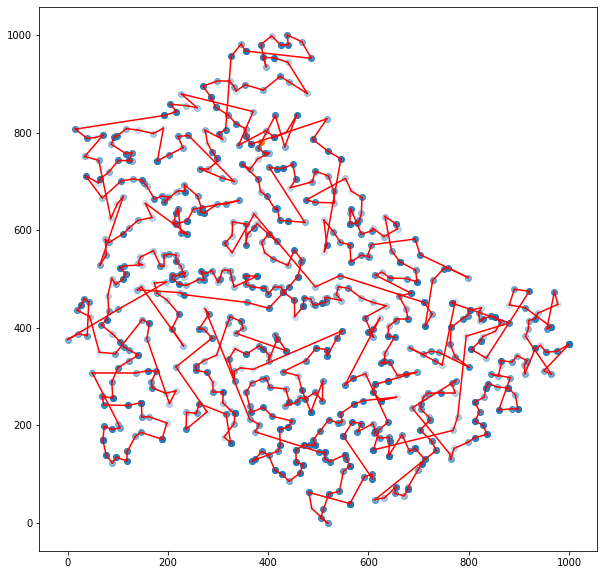

In [836]:
plt.figure(figsize=(10, 10))

for i in np.arange(1, x.shape[0]):
    plt.scatter(x[i], y[i], color=blue, alpha=costs[i]/np.max(good_costs))

plt.scatter(x[zero_pos], y[zero_pos], color=orange)

for i in range(1, len(result_path)):
    x1, y1 = islands[result_path[i - 1]].x, islands[result_path[i - 1]].y
    x2, y2 = islands[result_path[i]].x, islands[result_path[i]].y
    plt.plot([x1, x2], [y1, y2], c='red')
plt.show()

In [837]:
assert check(result_path)

In [838]:
d = deque()
summary = 0
for i in range(1, len(result_path)):
    cur = islands[result_path[i]].cost - p * point_dist(islands[result_path[i]], islands[result_path[i - 1]])
    summary += cur
summary

725287.8826718086

In [839]:
for i in result_path:
    print(i + 1, end=" ")

1 800 335 817 173 385 731 164 339 206 733 7 283 559 575 207 10 821 861 724 226 537 470 610 141 669 250 448 512 918 459 743 144 677 262 405 577 382 389 219 49 586 722 285 449 697 807 240 239 157 796 170 67 270 770 208 341 547 276 66 437 330 694 723 728 947 229 35 114 424 670 388 358 879 617 758 903 883 751 767 417 536 350 475 215 183 296 851 679 794 477 843 896 754 21 874 446 757 363 406 445 690 409 517 856 715 746 890 914 106 351 647 39 644 272 318 744 310 508 198 616 654 967 554 2 401 714 447 579 238 667 454 608 52 71 803 377 771 70 832 980 614 706 969 234 570 946 460 113 642 313 500 808 380 732 27 756 827 116 171 846 457 482 850 553 826 479 748 256 970 356 813 769 471 541 603 628 626 367 23 9 513 55 646 781 910 481 463 598 92 46 564 925 422 638 762 933 136 280 122 719 236 823 941 306 323 90 332 578 582 904 431 845 705 354 430 386 581 709 852 594 486 765 812 978 666 742 189 532 632 949 753 862 274 687 133 798 419 524 650 629 804 320 664 840 216 140 217 6 154 218 599 197 521 568 574 77

In [840]:
res = set()
for i in result_path:
    if i in res:
        print(i)
    res.add(i)

0


In [841]:
islands[558].cost

1232